# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn for visualization
import seaborn as sns
sns.set_style("darkgrid")

# Load sklearn
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC

# Load other ml models 
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

#Remove warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter(action='ignore', category=FutureWarning)

print('Project libraries has been successfully been imported!')

Project libraries has been successfully been imported!


In [2]:
# read the data
try:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
except:
    taxi = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]) 
    
print('Data has been read correctly!')

Data has been read correctly!


In [3]:
# Checking 0's
def zero_check(df):
    for i in df:
        print(i,len(df[df[i]==0]))
        
# function to determine if columns in file have null values        
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('{} has {} nulls, which is {:.{}%} percent of Nulls'.format(column, num_of_nulls, percent, num))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")       
        
# function to display general information about the dataset
def general_info(df):
    print("\033[1m" + "\033[0m")
    display(pd.concat([df.dtypes, df.count(),df.isna().sum(),df.isna().sum()/len(df)], keys=['type','count','na','na%'],
                      axis=1))
    print()
    print("\033[1m" + 'Head:')  
    display(df.head())
    print()
    print("\033[1m" + 'Tail:')
    display(df.tail())
    print()
    print("\033[1m" + 'Info:')
    print()
    display(df.info())
    print()
    print("\033[1m" + 'Describe:')
    print()
    display(df.describe())
    print()
    print("\033[1m" + 'Describe include: all :')
    print()
    display(df.describe(include='all'))
    print()
    print("\033[1m" + 'nulls in the columns:')
    print()
    display(get_percent_of_na(df, 4))  # check this out
    print()
    print("\033[1m" + 'Zeros in the columns:') 
    print()
    display(zero_check(df))
    print()
    print("\033[1m" + 'Shape:', df.shape)
    print()
    print()
    print('Duplicated:',"\033[1m" + 'We have {} duplicated rows\n'.format(df.duplicated().sum()) + "\033[0m")
    print()
    print("\033[1m" + 'Dtypes:')  
    display(df.dtypes)
    print()
    print("\033[1m" + 'correlation:')  
    display(df.corr())
    print()

In [4]:
#print our info data
print('information about Our "taxi" dataset:')
general_info(taxi)
print()

information about Our "taxi" dataset:



,type,count,na,na%
num_orders,int64,26496,0,0.0



Head:


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Tail:


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53



Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


Describe:



,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



Describe include: all :



,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



nulls in the columns:


There are no columns with NA.


None


Zeros in the columns:

num_orders 537


None


Shape: (26496, 1)


Duplicated: We have 26415 duplicated rows


Dtypes:


num_orders    int64
dtype: object


correlation:


,num_orders
num_orders,1.0


<hr><h2>Short brief of what we have part I:</h2>

- We load our libraries and dataset which we did parse_dates when it's load
<br>
- <u><b>we did first inspection to our data:</b></u>
  - our data is from Mar to Aug 2018  
  - base on dates and orders
  - there is 26415 duplicated rows
  - 'num_orders' have 537, 0's
  - 26496 rows  
<hr>

## Preparation

In [5]:
taxi = taxi.resample('1H').sum()
taxi.sort_index(inplace=True)
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [6]:
taxi['rolling_mean'] = taxi.rolling(24).mean()
taxi['std'] = taxi['num_orders'].rolling(24).std()
taxi

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,136,167.541667,63.268908
2018-08-31 20:00:00,154,168.041667,63.105487
2018-08-31 21:00:00,159,166.416667,62.801908


In [7]:
taxi.dropna(inplace=True)
taxi.isna().sum()

num_orders      0
rolling_mean    0
std             0
dtype: int64

<hr><h2>Short brief of what we did part II:</h2>

- We resampled our date to 1 hour

- Add rolling mean and standard deviation columns

- Fill our missing values with backfill method
<hr>

## Analysis

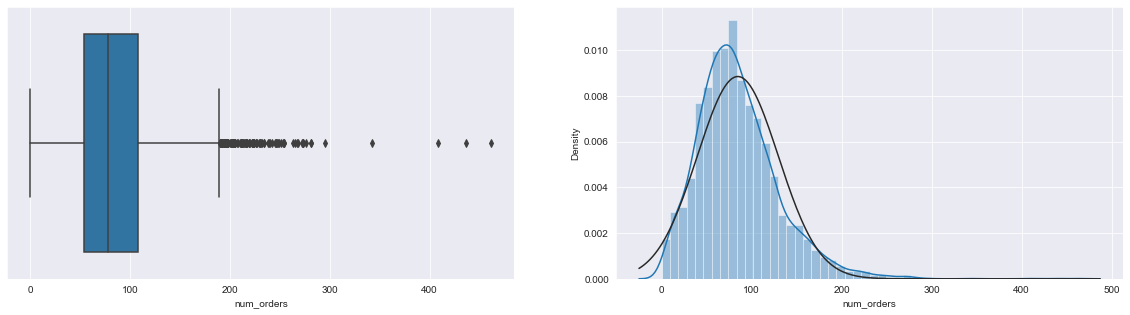

Num of orders has a normal distribution with several outliers


In [8]:
#Plot Num of orders to see the distribution and if there is outliers
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.boxplot(taxi["num_orders"], ax=ax[0])
sns.distplot(taxi["num_orders"], fit=norm, ax=ax[1])
plt.show();
print('Num of orders has a normal distribution with several outliers')

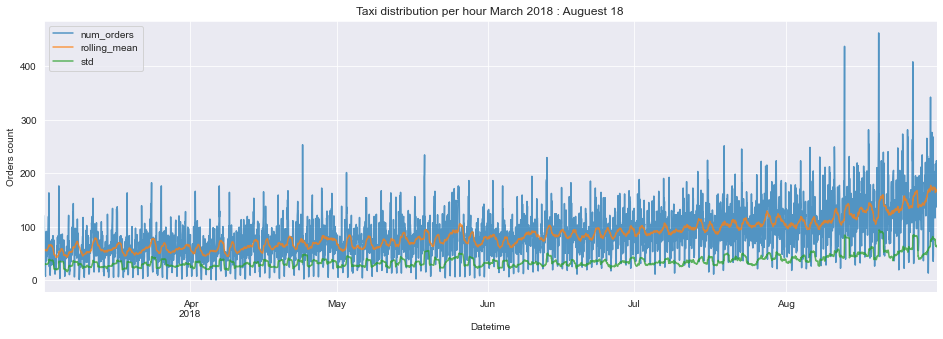

In [9]:
#Plot taxi data distribution hour from march 18 to Auguest 18
taxi.plot(grid=True,alpha=0.75,figsize=(16,5));
plt.title('Taxi distribution per hour March 2018 : Auguest 18');
plt.xlabel('Datetime');
plt.ylabel('Orders count');
plt.show();

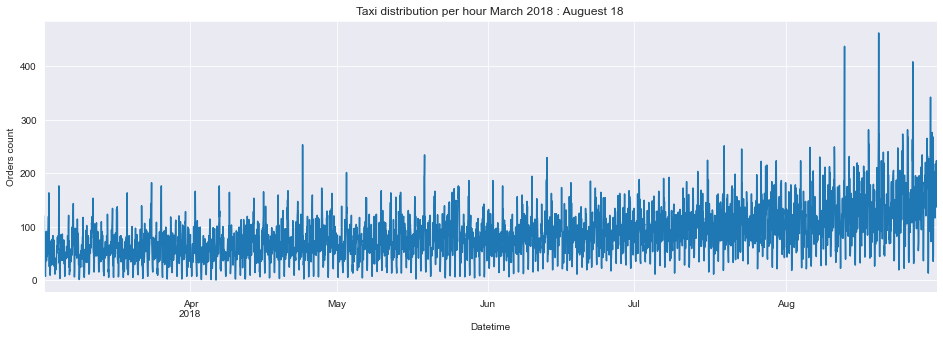

In [10]:
#Plot taxi data 'num orders' distribution hour from march 18 to Auguest 18 
plt.figure(figsize=(16,5))
taxi['num_orders'].plot()
plt.title('Taxi distribution per hour March 2018 : Auguest 18')
plt.xlabel('Datetime')
plt.ylabel('Orders count')
plt.show();

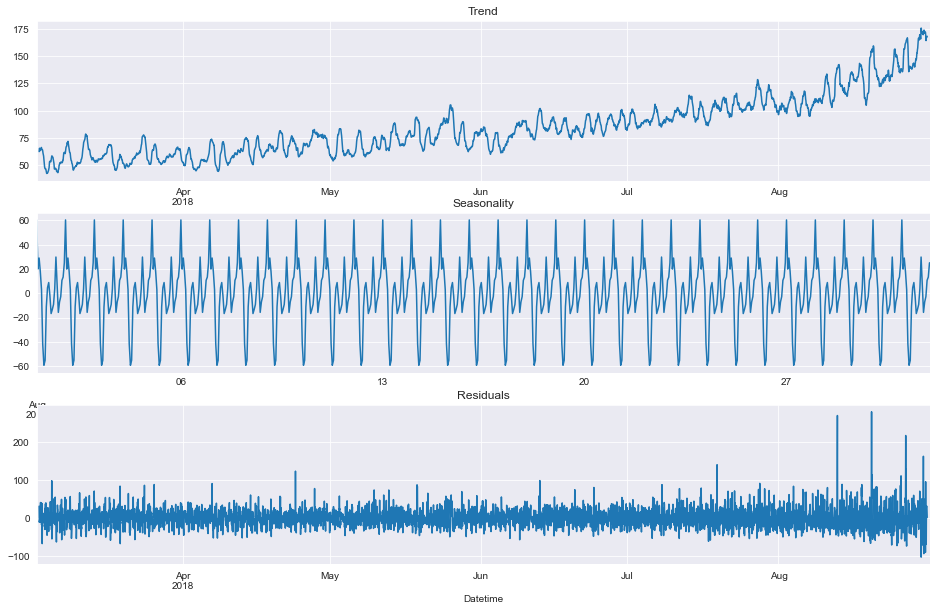

In [11]:
#Plotting Trend, Seasonality & Residuals
decomposed = seasonal_decompose(taxi['num_orders'])
plt.figure(figsize=(16,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('Datetime')
plt.show();

In [12]:
#Creating a stationary time series
#taxi_data = taxi - taxi.shift()
taxi_data = taxi.drop(['rolling_mean'], axis=1)
taxi_data = taxi.drop(['std'], axis=1)

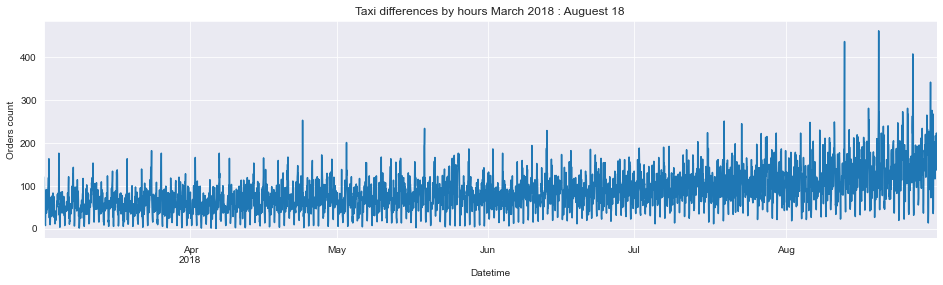

In [13]:
#plot Taxi differences by hours March 2018 : Auguest 18
plt.figure(figsize=(16,4))
taxi_data['num_orders'].plot()
plt.title('Taxi differences by hours March 2018 : Auguest 18')
plt.xlabel('Datetime')
plt.ylabel('Orders count')
plt.show();

<hr><h2>Short brief of what we did part III:</h2>

- Plot distribution of orders per hour on the entire data

- Plot distribution with rolling mean and standard deviation

- Plot & analyzed trend, seasonality, residuals for 'num_orders' column

- Drop all the columns except for 'num_orders' to return to initial data  without calculations

<b>What we found looking at our EDA</b>

First we can see that our 'num_orders' column have normal distribution with several outliers, also we notice that our 'trend' is increasing order when the summer months is coming when the highest peak as we can see is in Aug which is also the last month in our data.

when i look at our 'Seasonality' we can't see any dramatic movement and it's stay the same from start to the end and finally the 'residuals' it's not very clear i guess since our data is only few months long we can see some tiny movement over time and bigger one in the end.

we can see that our highest order peak is 00:00 , after it around ~16:00 and 10:00 , the lowest time is early morning around ~6:00. 
<hr>

## Training

In [18]:
#split data set (80-20 train-test sets)
train, test = train_test_split(taxi_data, shuffle=False, test_size=0.1)

#confirm size of datasets
print(taxi_data.shape)
print(train.shape)
print(test.shape)

(4393, 2)
(3953, 2)
(440, 2)


In [19]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 23:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [20]:
#using a constant value: median level of taxi orders so that you can correlate it with RMSE value
print('Median daily taxi orders:', test['num_orders'].median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('RMSE:', np.sqrt(mean_squared_error(test, pred_median)))

Median daily taxi orders: 135.0
RMSE: 77.23639233074204


In [21]:
#using the previous value in the series to predict the taxi orders and find the RMSE value for this prediction
print('Median daily taxi orders:', test['num_orders'].median())
pred_previous = np.ones(test.shape[0]) * test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])
print('RMSE:', np.sqrt(mean_squared_error(test['num_orders'], pred_previous)))

Median daily taxi orders: 135.0
RMSE: 58.881776776551476


In [22]:
#Creating features
def make_features(data, max_lag, rolling_mean_size, std_mean_size):
    taxi_data['year'] = taxi_data.index.year
    taxi_data['month'] = taxi_data.index.month
    taxi_data['week'] = taxi_data.index.week
    taxi_data['dayofweek'] = taxi_data.index.dayofweek
    taxi_data['day'] = taxi_data.index.day
    taxi_data['hour'] = taxi_data.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi_data['lag_{}'.format(lag)] = taxi_data['num_orders'].shift(lag)
    
    taxi_data['rolling_mean'] = taxi_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    taxi_data['std'] = taxi_data['num_orders'].shift().rolling(std_mean_size).mean()
    
make_features(taxi_data, 5, 10,10)
taxi_data.dropna(inplace=True)
taxi_data

,num_orders,rolling_mean,year,month,week,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,std
datetime,,,,,,,,,,,,,,
2018-03-02 09:00:00,45,50.2,2018,3,9,4,2,9,46.0,7.0,11.0,11.0,20.0,50.2
2018-03-02 10:00:00,54,48.9,2018,3,9,4,2,10,45.0,46.0,7.0,11.0,11.0,48.9
2018-03-02 11:00:00,91,45.3,2018,3,9,4,2,11,54.0,45.0,46.0,7.0,11.0,45.3
2018-03-02 12:00:00,36,42.4,2018,3,9,4,2,12,91.0,54.0,45.0,46.0,7.0,42.4
2018-03-02 13:00:00,45,38.5,2018,3,9,4,2,13,36.0,91.0,54.0,45.0,46.0,38.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,173.3,2018,8,35,4,31,19,207.0,217.0,197.0,116.0,133.0,173.3
2018-08-31 20:00:00,154,166.6,2018,8,35,4,31,20,136.0,207.0,217.0,197.0,116.0,166.6
2018-08-31 21:00:00,159,162.9,2018,8,35,4,31,21,154.0,136.0,207.0,217.0,197.0,162.9


In [23]:
train, test = train_test_split(taxi_data, shuffle=False, test_size=0.1)
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [24]:
train

,num_orders,rolling_mean,year,month,week,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,std
datetime,,,,,,,,,,,,,,
2018-03-02 09:00:00,45,50.2,2018,3,9,4,2,9,46.0,7.0,11.0,11.0,20.0,50.2
2018-03-02 10:00:00,54,48.9,2018,3,9,4,2,10,45.0,46.0,7.0,11.0,11.0,48.9
2018-03-02 11:00:00,91,45.3,2018,3,9,4,2,11,54.0,45.0,46.0,7.0,11.0,45.3
2018-03-02 12:00:00,36,42.4,2018,3,9,4,2,12,91.0,54.0,45.0,46.0,7.0,42.4
2018-03-02 13:00:00,45,38.5,2018,3,9,4,2,13,36.0,91.0,54.0,45.0,46.0,38.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 12:00:00,92,146.4,2018,8,33,0,13,12,144.0,156.0,137.0,91.0,39.0,146.4
2018-08-13 13:00:00,119,111.9,2018,8,33,0,13,13,92.0,144.0,156.0,137.0,91.0,111.9
2018-08-13 14:00:00,102,107.0,2018,8,33,0,13,14,119.0,92.0,144.0,156.0,137.0,107.0


In [25]:
test

,num_orders,rolling_mean,year,month,week,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,std
datetime,,,,,,,,,,,,,,
2018-08-13 17:00:00,152,119.9,2018,8,33,0,13,17,144.0,175.0,102.0,119.0,92.0,119.9
2018-08-13 18:00:00,104,131.2,2018,8,33,0,13,18,152.0,144.0,175.0,102.0,119.0,131.2
2018-08-13 19:00:00,91,132.5,2018,8,33,0,13,19,104.0,152.0,144.0,175.0,102.0,132.5
2018-08-13 20:00:00,82,127.9,2018,8,33,0,13,20,91.0,104.0,152.0,144.0,175.0,127.9
2018-08-13 21:00:00,160,120.5,2018,8,33,0,13,21,82.0,91.0,104.0,152.0,144.0,120.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,173.3,2018,8,35,4,31,19,207.0,217.0,197.0,116.0,133.0,173.3
2018-08-31 20:00:00,154,166.6,2018,8,35,4,31,20,136.0,207.0,217.0,197.0,116.0,166.6
2018-08-31 21:00:00,159,162.9,2018,8,35,4,31,21,154.0,136.0,207.0,217.0,197.0,162.9


In [26]:
#Creating a dummy model with LinearRegression
model = LinearRegression()
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
predictions_train = model.predict(features_train)
print("MAE for the train set:", mean_absolute_error(predictions_train, target_train))

MAE for the train set: 23.42908741774291


In [27]:
### Creating pipelines
pipe_dtr = Pipeline([('scaler0', StandardScaler()), ('DecisionTreeRegressor', DecisionTreeRegressor())])

pipe_rfr = Pipeline([('scaler1', StandardScaler()), ('RandomForestRegressor', RandomForestRegressor(n_estimators=100))])

pipe_linear = Pipeline([('scaler2', StandardScaler()), ('LinearRegression(Dummy)', LinearRegression())])

pipe_cat_boost_r = Pipeline([('scaler3', StandardScaler()), ('CatBoostRegressor', CatBoostRegressor(verbose=500))])

pipe_lgbm_r =  Pipeline([('scaler4', StandardScaler()), ('LGBMRegressor', LGBMRegressor())])

pipe_xgb_r = Pipeline([('scaler5', StandardScaler()), ('XGBRegressor', XGBRegressor())])

In [28]:
#Creating list of pipelines
pipelines = [pipe_dtr, pipe_rfr, pipe_linear, pipe_cat_boost_r, pipe_lgbm_r, pipe_xgb_r]

#Creating a dict of pipelines
pipe_dict = {pipe_dtr: 'DecisionTreeRegressor', pipe_rfr:'RandomForestRegressor', pipe_linear:'LinearRegression',\
             pipe_cat_boost_r: 'CatBoostRegressor', pipe_lgbm_r: 'LGBMRegressor', pipe_xgb_r:'XGBRegressor'}

In [29]:
#Defining a fn to calc RMSE
def rmse(target,predictions): 
    score = mean_squared_error(target, predictions)
    score = score **0.5
    return score

In [30]:
#obtain Time Series Split
tscv = TimeSeriesSplit()

#Looping trough pipelines to obtain cross validation scores
rmse = make_scorer(rmse, greater_is_better=False)
for pipe in pipelines:
    print(pipe_dict[pipe])
    print(cross_val_score(pipe, features_train, target_train, scoring = rmse, cv = tscv))

DecisionTreeRegressor
[-29.94373211 -30.42104335 -33.57077532 -36.31544111 -39.07998277]
RandomForestRegressor
[-23.50423164 -22.20179724 -23.93459324 -24.30460369 -30.7866844 ]
LinearRegression
[-27.16995685 -28.79829867 -30.28601204 -32.07088589 -39.53796341]
CatBoostRegressor
Learning rate set to 0.038332
0:	learn: 28.9415685	total: 142ms	remaining: 2m 22s
500:	learn: 8.9943617	total: 1.19s	remaining: 1.18s
999:	learn: 4.8034668	total: 2.32s	remaining: 0us
Learning rate set to 0.042758
0:	learn: 29.9442115	total: 4.73ms	remaining: 4.73s
500:	learn: 11.0749096	total: 1.15s	remaining: 1.15s
999:	learn: 7.2831317	total: 2.39s	remaining: 0us
Learning rate set to 0.045584
0:	learn: 31.3658970	total: 3.16ms	remaining: 3.16s
500:	learn: 12.5534797	total: 1.35s	remaining: 1.34s
999:	learn: 8.8710081	total: 2.78s	remaining: 0us
Learning rate set to 0.047702
0:	learn: 32.6616819	total: 3.64ms	remaining: 3.63s
500:	learn: 13.8681475	total: 1.49s	remaining: 1.48s
999:	learn: 10.3349714	total: 3

In [31]:
#Creating a tree based model with best hyperparameters
parameters = {'n_estimators': (110,150,200,230,250,80,300),'max_depth': (7,8,10,12,16,19,25)} 

#Creating a grid model
RF_grid=GridSearchCV(RandomForestRegressor(random_state=0,criterion='mse'),param_grid=parameters, cv=tscv, scoring=rmse,
                     n_jobs=-1)
RF_grid_model = RF_grid.fit(features_train, target_train)
print(RF_grid_model.best_estimator_)
print(RF_grid_model.best_score_)

RandomForestRegressor(criterion='mse', max_depth=19, n_estimators=110,
                      random_state=0)
-24.77028810486548


In [32]:
#Creating a gradient boosting descent model with best hyperparameters
parameters = {'learning_rate': (0.15,0.1,0.2,0.3,0.25,0.05),'n_estimators': (200,350,450,150,100,120),
              'base_score': (0.25, 0.5, 0.75)} 

#Creating a grid model
XGB_grid = GridSearchCV(XGBRegressor(), param_grid=parameters, cv=tscv, scoring=rmse, n_jobs=-1) 
XGB_grid_model = XGB_grid.fit(features_train, target_train)
print(XGB_grid_model.best_estimator_)
print(XGB_grid_model.best_score_)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=120, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
-25.825373809418988


In [33]:
#Creating a gradient boosting descent model tuning best hyperparameters
parameters = {'learning_rate': (0.05,0.04,0.03,0.02,0.06,0.07,0.08),'n_estimators': (200,350,450,150,100,120)} 

#Creating a grid model
LGBM_grid = GridSearchCV(LGBMRegressor(), param_grid=parameters, cv=tscv, scoring=rmse, n_jobs=1) 
LGBM_grid_model = LGBM_grid.fit(features_train, target_train)
print(LGBM_grid_model.best_estimator_)
print(LGBM_grid_model.best_score_)

LGBMRegressor(learning_rate=0.03, n_estimators=200)
-24.870804049862738


<hr><h2>Short brief of what we did part IV:</h2>

Divided train and test assign test size = 0.1, shuffle = False

<b>Train index:</b> \
2018-03-01 23:00:00 2018-08-13 15:00:00

<b>Test index:</b> \
2018-08-13 16:00:00 2018-08-31 23:00:00

<hr>
We calculating MAE using median and previous prediction method obtained:

<b>Median method returned RMSE:</b> \
77.23639233074204

<b>Previous value method returned RMSE:</b> \
58.881776776551476

<hr>
We create features of the data extract: day , month and year from the index , assign five level of lags. 10 of them was the chosen value to calc again rolling_mean and standard deviation from the final shift values. Recreate train and test set with the same parameters after adding the new features column.

<hr>
With a base of 'Linear Regression(Dummy model)' calc the 'MAE':

<b>MAE for the training set :</b> \
23.429087417742917

<hr>
Create a Pipelines for the CV on the main models, After CV on training set we got the follow results:

<b>DecisionTreeRegressor :</b> \
[-33.32161895 -40.36237115]

<b>RandomForestRegressor :</b> \
[-24.80131275 -30.95330194]

<b>LinearRegression :</b> \
[-29.79124355 -36.31491973]

<b>CatBoostRegressor :</b> \
[-25.53956266 -30.42970528]

<b>LGBMRegressor :</b> \
[-25.17324933 -30.72094304]

<b>XGBRegressor :</b> \
[-26.85527657 -33.15660012]

<hr>
We decided to tune with <b>'hyperparameters'</b> the <b>RandomForestRegressor</b> & <b>XGBRegressor</b> (gradient descent algorithim) 
<hr>

<hr>

## Final Choice Testing model

In [35]:
model = Pipeline([('scaler2', StandardScaler()),
        ('XGBRegressor', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=1, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1))])
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
print('Model RMSE for the test set:', mean_squared_error(predictions_test, target_test)**0.5)

Model RMSE for the test set: 43.03925572796831


<hr><h2>Short brief of what we did part V:</h2>

Our final model in test set is our best one in the train set 'XGBRegressor' with RMSE 25.82 , as we can see that our model bring combo of great values and didn't pass the max value goal project 48.

<b>XGBRegressor :</b> \
43.03925572796831

<hr><h2>Overall Conclusion</h2>

In this project we been ask to build a model to predict the amount of orders for the next hour for <b>Sweet Lift Taxi company</b> the requirement was that the model 'RMSE' metric on the test set will not pass the value of 48. After preparing and analyzing the data we start to train and test phase. We tried couple of different models and preformed the task pretty similar ways. Obtain better result then the stated one. Our best result in both testing was 'XGBRegressor ' with 25.82 in RMSE (train set) and 43.03 in RMSE (test set).

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48